In [1]:
import numpy as np
import os 
import cv2
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import imutils
from datetime import datetime
from skimage.transform import resize

In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from tensorflow.keras.layers import Conv3D,ConvLSTM2D,Conv3DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

####     Part-2 (extracting frames)

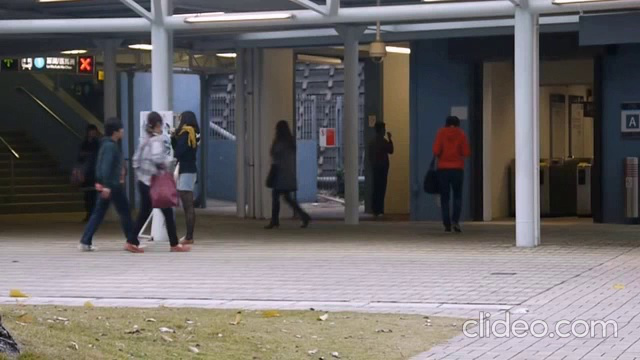

In [5]:
img=image.load_img('train/frames1/frame8000.jpg')
img

In [3]:
train_path=os.listdir("train/frames1")
storage=[i for i in train_path]
print('Total frames for training: ', len(storage))

Total frames for training:  15351


In [4]:
# locating directory
directory=os.getcwd()
print('Current directory is: ', directory)

Current directory is:  C:\Users\arvin.DO-NOT-DISTURB\Desktop\project\DONE\intelligent_survillence_system\project


### Part-2 ( Data processing)

In [6]:
start = datetime.now()
def store_inarray(image_path):
    image=load_img(image_path)
    image=img_to_array(image)
    image=cv2.resize(image, (227,227), interpolation = cv2.INTER_AREA)
    gray=0.2989*image[:,:,0]+0.5870*image[:,:,1]+0.1140*image[:,:,2]
    store_image.append(gray)

store_image=[]
train_image_path='train/frames1'
image=os.listdir(train_image_path)
for i in image:
    image_path=train_image_path+'/'+i
    store_inarray(image_path)

print("Total time taken for tuning hyperparameter and making prediction by the model is (HH:MM:SS): {}\n".format(datetime.now() - start))

Total time taken for tuning hyperparameter and making prediction by the model is (HH:MM:SS): 0:01:52.468299



In [5]:
# store_image.

In [ ]:
store_image=np.array(store_image)
a,b,c=store_image.shape
store_image.resize(b,c,a)
store_image=(store_image-store_image.mean())/(store_image.std())
store_image=np.clip(store_image,0,1)
np.save('training.npy',store_image) 

In [8]:
asd=np.load("training.npy")
asd

array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 5.3086999e-04, 1.0276143e-02],
        [7.7742733e-02, 8.0117449e-02, 9.2843771e-02, ...,
         8.6939520e-01, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        ...,
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 9.9045026e-01, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         8.9892107e-01, 1.0000000e+00, 1.0000000e+00],
        [9.4856495e-01, 1.0000000e+00, 1.0000000e+00, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 7.0363760e-01, ...,
         0.000

#### Part-3

In [9]:
# CNN model
cnn=Sequential()

cnn.add(Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',input_shape=(227,227,10,1),activation='tanh'))
cnn.add(Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))
cnn.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True))
cnn.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True))
cnn.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))
cnn.add(Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))
cnn.add(Conv3DTranspose(filters=1,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',activation='tanh'))

cnn.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 55, 55, 10, 128)   15616     
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 26, 26, 10, 64)    204864    
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 26, 26, 10, 64)    295168    
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 26, 26, 10, 32)    110720    
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 26, 26, 10, 64)    221440    
_________________________________________________________________
conv3d_transpose (Conv3DTran (None, 55, 55, 10, 128)   204928    
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 227, 227, 10, 1)   1

In [10]:
training_data=np.load('training.npy')
frames=training_data.shape[2]
frames=frames-frames%10

training_data=training_data[:,:,:frames]
training_data=training_data.reshape(-1,227,227,10)
training_data=np.expand_dims(training_data,axis=4)  # data augmentation
target_data=training_data.copy()

In [12]:
start = datetime.now()
epochs=10
batch_size=1

callback_save = ModelCheckpoint("saved_model.h5", 
                                mode='min',
                                monitor="mean_squared_error", 
                                save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', 
                                        verbose=1,  # we can add verbose=1 and remove epoch, wat it will do is that it will
                                                    # stop training and will stop when model stop to improve and will return
                                                    # number of epoch
                                        mode='min',
                                        patience=3)

history_1=cnn.fit(training_data,target_data, 
               validation_split=0.3,
               batch_size=batch_size, 
               epochs=epochs, 
               callbacks = [callback_save,callback_early_stopping])
cnn.save("saved_model.h5")
print("-------------------------------------------------------")
print("Total time taken for training is (HH:MM:SS): {}\n".format(datetime.now() - start))
print("-------------------------------------------------------")
print("      Training done and model is ready for testing     ")
print("-------------------------------------------------------")

Epoch 1/10
1074/1074 [==============================] - 1758s 2s/step - loss: 0.0888 - accuracy: 0.7100 - val_loss: 0.0920 - val_accuracy: 0.7177
Epoch 2/10
1074/1074 [==============================] - 2119s 2s/step - loss: 0.0708 - accuracy: 0.7328 - val_loss: 0.0859 - val_accuracy: 0.7245
Epoch 3/10
1074/1074 [==============================] - 1751s 2s/step - loss: 0.0694 - accuracy: 0.7340 - val_loss: 0.0845 - val_accuracy: 0.7247
Epoch 4/10
1074/1074 [==============================] - 2745s 3s/step - loss: 0.0688 - accuracy: 0.7346 - val_loss: 0.0838 - val_accuracy: 0.7270
Epoch 5/10
1074/1074 [==============================] - 3963s 4s/step - loss: 0.0686 - accuracy: 0.7350 - val_loss: 0.0834 - val_accuracy: 0.7264
Epoch 6/10
1074/1074 [==============================] - 2552s 2s/step - loss: 0.0540 - accuracy: 0.7484 - val_loss: 0.0499 - val_accuracy: 0.7605
Epoch 7/10
1074/1074 [==============================] - 1623s 2s/step - loss: 0.0280 - accuracy: 0.7741 - val_loss: 0.0462 -

In [ ]:
# plotting acc, val_acc, loss, val_loss
import pandas as pd
pd.DataFrame(history_1.history).plot(figsize=(10, 7))

In [ ]:
# m-1

# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# m-2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'def 
plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()